<a href="https://colab.research.google.com/github/shuheimisawa/annotate_tpath/blob/main/01_data_inventory_and_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic Setup and Authentication

```
# This is formatted as code
```



In [1]:
from google.colab import auth
auth.authenticate_user()

# Project configuration
PROJECT_ID = "gen-lang-client-0716540381"
BUCKET_NAME = "project_tpath"
EXPECTED_SLIDE_COUNT = 169

print(f"Project: {PROJECT_ID}")
print(f"Bucket: {BUCKET_NAME}")
print("Authentication complete!")

Project: gen-lang-client-0716540381
Bucket: project_tpath
Authentication complete!


Cell 2 - Essential Packages:

In [9]:
!pip install -q google-cloud-storage
!pip install -q openslide-python
!pip install -q shapely matplotlib seaborn

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import storage
from shapely.geometry import Polygon
from collections import Counter
from pathlib import Path

# Connect to GCS
client = storage.Client(project=PROJECT_ID)
bucket = client.bucket(BUCKET_NAME)

print("Basic setup ready!")

Basic setup ready!


WSI File Inventory

In [3]:
# Simple WSI file scan
print("Scanning WSI files...")

wsi_blobs = list(bucket.list_blobs(prefix="raw_wsi/"))
wsi_files = []

for blob in wsi_blobs:
    if blob.name.endswith(('.svs', '.tiff', '.tif', '.ndpi')):
        wsi_files.append({
            'filename': blob.name.split('/')[-1],
            'base_name': Path(blob.name).stem,
            'size_mb': blob.size / (1024 * 1024) if blob.size else 0
        })

print(f"Found {len(wsi_files)} WSI files (expected {EXPECTED_SLIDE_COUNT})")

# Show first few
for i, f in enumerate(wsi_files[:5]):
    print(f"  {f['filename']} ({f['size_mb']:.1f} MB)")

if len(wsi_files) > 5:
    print(f"  ... and {len(wsi_files) - 5} more")

Scanning WSI files...
Found 147 WSI files (expected 169)
  TPATH001.svs (318.7 MB)
  TPATH002.svs (243.0 MB)
  TPATH003.svs (216.9 MB)
  TPATH004.svs (128.2 MB)
  TPATH005.svs (209.6 MB)
  ... and 142 more


Qupath Annotation Inventory:

In [12]:
# Scan QuPath annotation files
print("Scanning QuPath annotations...")

annotation_blobs = list(bucket.list_blobs(prefix="qupath_annotations/"))
annotation_files = []

for blob in annotation_blobs:
    if blob.name.endswith('.geojson'):
        annotation_files.append({
            'filename': blob.name.split('/')[-1],
            'base_name': blob.name.split('/')[-1].replace('.geojson', ''),
            'size_kb': blob.size / 1024 if blob.size else 0
        })

print(f"Found {len(annotation_files)} annotation files")

# Match WSI files with annotations
wsi_names = {f['base_name'] for f in wsi_files}
annotation_names = {f['base_name'] for f in annotation_files}

matched = wsi_names.intersection(annotation_names)
wsi_without_annotations = wsi_names - annotation_names
annotations_without_wsi = annotation_names - wsi_names

print(f"Matched pairs: {len(matched)}")
print(f"WSI without annotations: {len(wsi_without_annotations)}")
print(f"Annotations without WSI: {len(annotations_without_wsi)}")

if wsi_without_annotations:
    print("WSI files missing annotations:", list(wsi_without_annotations)[:5])

Scanning QuPath annotations...
Found 2 annotation files
Matched pairs: 2
WSI without annotations: 145
Annotations without WSI: 0
WSI files missing annotations: ['TPATH115', 'TPATH141', 'TPATH074', 'TPATH004', 'TPATH066']


Annotation Analysis

Running comprehensive annotation analysis...
Analyzing 2 annotation files...

=== ANNOTATION ANALYSIS RESULTS ===
Total annotations across all slides: 369
Class distribution:
  Normal: 329 (89.2%)
  Sclerotic: 40 (10.8%)
  Other: 0 (0.0%)

Annotation density per slide:
  Mean: 184.5
  Median: 184.5
  Min: 177
  Max: 192
  Std: 7.5

Polygon size analysis:
  Mean area: 211331
  Median area: 209810
  Area range: 31648 - 510249

Polygon complexity analysis:
  Mean vertices: 670.3
  Median vertices: 666.5
  Complexity range: 199 - 1473

Data quality assessment:
  Malformed polygons: 0
  Slides with processing errors: 0
  Slides with no annotations: 0
  Slides with unusually many annotations: 0


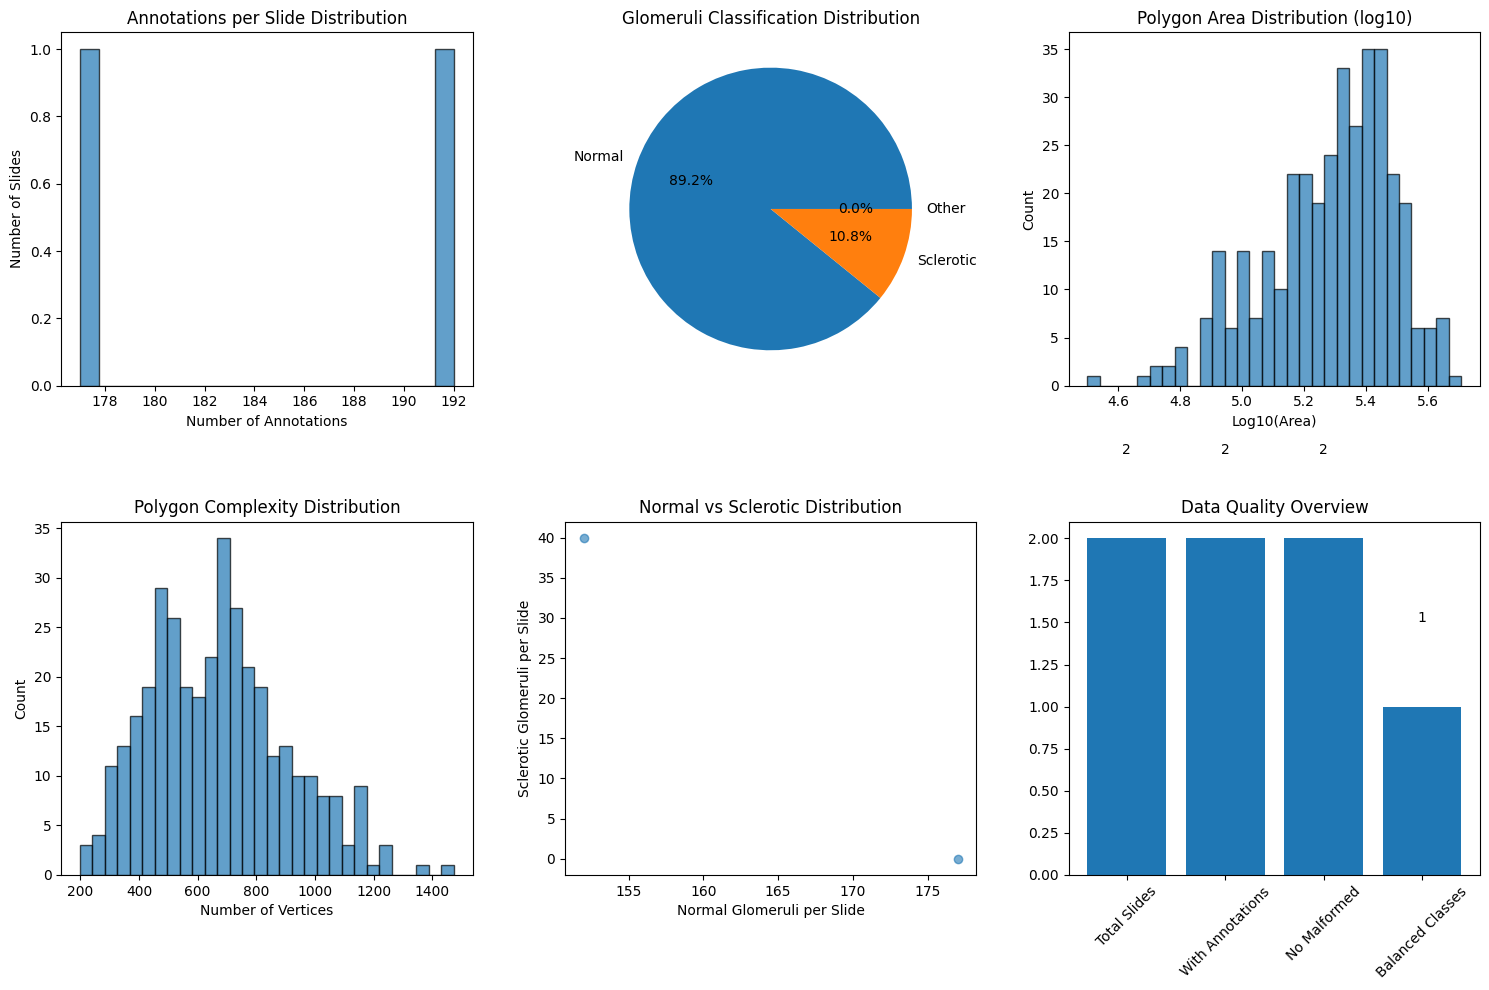


=== COMPREHENSIVE ANNOTATION ANALYSIS COMPLETE ===


In [11]:
print("Running comprehensive annotation analysis...")

# Analyze ALL annotation files for complete picture
all_annotation_data = []
class_counts = {'Normal': 0, 'Sclerotic': 0, 'Other': 0}
polygon_areas = []
polygon_complexities = []
slide_stats = []

print(f"Analyzing {len(annotation_files)} annotation files...")

for i, annotation_file in enumerate(annotation_files):
    try:
        blob = bucket.blob(f"qupath_annotations/{annotation_file['filename']}")
        content = blob.download_as_text()
        data = json.loads(content)

        features = data.get('features', [])
        slide_classes = {'Normal': 0, 'Sclerotic': 0, 'Other': 0}
        slide_areas = []
        slide_complexities = []
        malformed_polygons = 0

        for feature in features:
            # Classification analysis
            classification = feature.get('properties', {}).get('classification', {}).get('name', 'Unknown')

            if any(term in classification.lower() for term in ['normal', 'glomerulus']):
                slide_classes['Normal'] += 1
                class_counts['Normal'] += 1
            elif any(term in classification.lower() for term in ['sclerotic', 'sclerosed']):
                slide_classes['Sclerotic'] += 1
                class_counts['Sclerotic'] += 1
            else:
                slide_classes['Other'] += 1
                class_counts['Other'] += 1

            # Geometric analysis
            geometry = feature.get('geometry', {})
            if geometry.get('type') == 'Polygon':
                try:
                    coords = geometry['coordinates'][0]
                    if len(coords) >= 4:  # Valid polygon needs at least 4 points
                        # Calculate area (bounding box approximation)
                        x_coords = [point[0] for point in coords]
                        y_coords = [point[1] for point in coords]
                        bbox_area = (max(x_coords) - min(x_coords)) * (max(y_coords) - min(y_coords))
                        slide_areas.append(bbox_area)
                        polygon_areas.append(bbox_area)

                        # Calculate complexity (number of vertices)
                        complexity = len(coords)
                        slide_complexities.append(complexity)
                        polygon_complexities.append(complexity)

                        # Try to create Shapely polygon to check validity
                        try:
                            poly = Polygon(coords)
                            if not poly.is_valid:
                                malformed_polygons += 1
                        except:
                            malformed_polygons += 1
                    else:
                        malformed_polygons += 1
                except Exception:
                    malformed_polygons += 1

        # Store slide-level statistics
        slide_stat = {
            'slide': annotation_file['base_name'],
            'total_annotations': len(features),
            'normal': slide_classes['Normal'],
            'sclerotic': slide_classes['Sclerotic'],
            'other': slide_classes['Other'],
            'mean_area': np.mean(slide_areas) if slide_areas else 0,
            'median_area': np.median(slide_areas) if slide_areas else 0,
            'mean_complexity': np.mean(slide_complexities) if slide_complexities else 0,
            'malformed_polygons': malformed_polygons,
            'annotation_density': len(features) / (max(slide_areas) if slide_areas else 1)
        }
        slide_stats.append(slide_stat)

        if (i + 1) % 20 == 0:
            print(f"  Processed {i + 1}/{len(annotation_files)} files...")

    except Exception as e:
        print(f"  Error processing {annotation_file['filename']}: {str(e)}")
        slide_stats.append({
            'slide': annotation_file['base_name'],
            'error': str(e)
        })

print("\n=== ANNOTATION ANALYSIS RESULTS ===")

# Class distribution
total_annotations = sum([s.get('total_annotations', 0) for s in slide_stats])
print(f"Total annotations across all slides: {total_annotations}")
print(f"Class distribution:")
print(f"  Normal: {class_counts['Normal']} ({class_counts['Normal']/total_annotations*100:.1f}%)")
print(f"  Sclerotic: {class_counts['Sclerotic']} ({class_counts['Sclerotic']/total_annotations*100:.1f}%)")
print(f"  Other: {class_counts['Other']} ({class_counts['Other']/total_annotations*100:.1f}%)")

# Annotation density analysis
annotation_counts = [s.get('total_annotations', 0) for s in slide_stats if 'error' not in s]
print(f"\nAnnotation density per slide:")
print(f"  Mean: {np.mean(annotation_counts):.1f}")
print(f"  Median: {np.median(annotation_counts):.1f}")
print(f"  Min: {np.min(annotation_counts)}")
print(f"  Max: {np.max(annotation_counts)}")
print(f"  Std: {np.std(annotation_counts):.1f}")

# Geometric analysis
if polygon_areas:
    print(f"\nPolygon size analysis:")
    print(f"  Mean area: {np.mean(polygon_areas):.0f}")
    print(f"  Median area: {np.median(polygon_areas):.0f}")
    print(f"  Area range: {np.min(polygon_areas):.0f} - {np.max(polygon_areas):.0f}")

if polygon_complexities:
    print(f"\nPolygon complexity analysis:")
    print(f"  Mean vertices: {np.mean(polygon_complexities):.1f}")
    print(f"  Median vertices: {np.median(polygon_complexities):.1f}")
    print(f"  Complexity range: {np.min(polygon_complexities)} - {np.max(polygon_complexities)}")

# Data quality issues
total_malformed = sum([s.get('malformed_polygons', 0) for s in slide_stats])
print(f"\nData quality assessment:")
print(f"  Malformed polygons: {total_malformed}")
print(f"  Slides with processing errors: {len([s for s in slide_stats if 'error' in s])}")

# Edge cases detection
slides_no_annotations = [s for s in slide_stats if s.get('total_annotations', 0) == 0]
slides_many_annotations = [s for s in slide_stats if s.get('total_annotations', 0) > np.mean(annotation_counts) + 2*np.std(annotation_counts)]

print(f"  Slides with no annotations: {len(slides_no_annotations)}")
print(f"  Slides with unusually many annotations: {len(slides_many_annotations)}")

if slides_no_annotations:
    print(f"    No annotations: {[s['slide'] for s in slides_no_annotations][:5]}")
if slides_many_annotations:
    # Fixed the f-string issue here
    many_annot_list = []
    for s in slides_many_annotations[:3]:
        many_annot_list.append(f"{s['slide']}({s.get('total_annotations', 0)})")
    print(f"    Many annotations: {many_annot_list}")

# Visualization
plt.figure(figsize=(15, 10))

# Subplot 1: Annotation count distribution
plt.subplot(2, 3, 1)
plt.hist(annotation_counts, bins=20, alpha=0.7, edgecolor='black')
plt.title('Annotations per Slide Distribution')
plt.xlabel('Number of Annotations')
plt.ylabel('Number of Slides')

# Subplot 2: Class distribution pie chart
plt.subplot(2, 3, 2)
class_values = [class_counts['Normal'], class_counts['Sclerotic'], class_counts['Other']]
class_labels = ['Normal', 'Sclerotic', 'Other']
plt.pie(class_values, labels=class_labels, autopct='%1.1f%%')
plt.title('Glomeruli Classification Distribution')

# Subplot 3: Polygon area distribution
if polygon_areas:
    plt.subplot(2, 3, 3)
    plt.hist(np.log10(polygon_areas), bins=30, alpha=0.7, edgecolor='black')
    plt.title('Polygon Area Distribution (log10)')
    plt.xlabel('Log10(Area)')
    plt.ylabel('Count')

# Subplot 4: Polygon complexity
if polygon_complexities:
    plt.subplot(2, 3, 4)
    plt.hist(polygon_complexities, bins=30, alpha=0.7, edgecolor='black')
    plt.title('Polygon Complexity Distribution')
    plt.xlabel('Number of Vertices')
    plt.ylabel('Count')

# Subplot 5: Normal vs Sclerotic per slide
plt.subplot(2, 3, 5)
normal_counts = [s.get('normal', 0) for s in slide_stats if 'error' not in s]
sclerotic_counts = [s.get('sclerotic', 0) for s in slide_stats if 'error' not in s]
plt.scatter(normal_counts, sclerotic_counts, alpha=0.6)
plt.xlabel('Normal Glomeruli per Slide')
plt.ylabel('Sclerotic Glomeruli per Slide')
plt.title('Normal vs Sclerotic Distribution')

# Subplot 6: Annotation quality overview
plt.subplot(2, 3, 6)
quality_metrics = ['Total Slides', 'With Annotations', 'No Malformed', 'Balanced Classes']
quality_values = [
    len(slide_stats),
    len([s for s in slide_stats if s.get('total_annotations', 0) > 0]),
    len([s for s in slide_stats if s.get('malformed_polygons', 0) == 0]),
    len([s for s in slide_stats if s.get('normal', 0) > 0 and s.get('sclerotic', 0) > 0])
]
bars = plt.bar(quality_metrics, quality_values)
plt.title('Data Quality Overview')
plt.xticks(rotation=45)
for i, v in enumerate(quality_values):
    plt.text(i, v + 0.5, str(v), ha='center')

plt.tight_layout()
plt.show()

print("\n=== COMPREHENSIVE ANNOTATION ANALYSIS COMPLETE ===")

# Store results for next processing steps
annotation_analysis_results = {
    'slide_stats': slide_stats,
    'class_counts': class_counts,
    'polygon_areas': polygon_areas,
    'polygon_complexities': polygon_complexities,
    'total_annotations': total_annotations,
    'analysis_date': pd.Timestamp.now().isoformat()
}

Data Quality Checks:

In [7]:
print("Running data quality checks...")

# Check for naming consistency
wsi_naming_patterns = set()
for f in wsi_files:
    # Extract naming pattern (assuming format like TPATH001, etc.)
    if len(f['base_name']) > 3:
        pattern = f['base_name'][:5] if f['base_name'][:5].isalpha() else f['base_name'][:3]
        wsi_naming_patterns.add(pattern)

print(f"WSI naming patterns found: {wsi_naming_patterns}")

# Check file size outliers
import numpy as np
sizes = [f['size_mb'] for f in wsi_files]
mean_size = np.mean(sizes)
std_size = np.std(sizes)

outliers = []
for f in wsi_files:
    if abs(f['size_mb'] - mean_size) > 2 * std_size:
        outliers.append(f)

print(f"File size statistics (MB): mean={mean_size:.1f}, std={std_size:.1f}")
if outliers:
    print(f"Size outliers found: {len(outliers)}")
    for outlier in outliers[:3]:
        print(f"  {outlier['filename']}: {outlier['size_mb']:.1f} MB")

# Check for duplicate base names
base_names = [f['base_name'] for f in wsi_files]
duplicates = [name for name in set(base_names) if base_names.count(name) > 1]
if duplicates:
    print(f"Duplicate base names found: {duplicates}")
else:
    print("No duplicate base names found")

Running data quality checks...
WSI naming patterns found: {'TPATH'}
File size statistics (MB): mean=168.8, std=103.7
Size outliers found: 8
  TPATH067.svs: 395.7 MB
  TPATH095.svs: 446.6 MB
  TPATH102.svs: 442.1 MB
No duplicate base names found


Cell Processing Capacity Planning

In [14]:
print("=== PROCESSING CAPACITY PLANNING ===")

# Calculate processing requirements
total_annotations = 369
avg_annotations_per_slide = 184.5
estimated_full_dataset_annotations = avg_annotations_per_slide * EXPECTED_SLIDE_COUNT

print(f"Current dataset: 2 slides, {total_annotations} annotations")
print(f"Projected full dataset: {EXPECTED_SLIDE_COUNT} slides, ~{estimated_full_dataset_annotations:.0f} annotations")

# Memory estimation for feature extraction
bytes_per_annotation = 2048 * 4  # ResNet50 features (2048 float32)
current_memory_mb = (total_annotations * bytes_per_annotation) / (1024 * 1024)
projected_memory_mb = (estimated_full_dataset_annotations * bytes_per_annotation) / (1024 * 1024)

print(f"\nMemory requirements for feature storage:")
print(f"  Current (2 slides): {current_memory_mb:.1f} MB")
print(f"  Full dataset: {projected_memory_mb:.1f} MB ({projected_memory_mb/1024:.2f} GB)")

# Processing time estimation
seconds_per_annotation = 0.5  # Conservative estimate for ResNet50 feature extraction
current_processing_time = (total_annotations * seconds_per_annotation) / 60
full_processing_time = (estimated_full_dataset_annotations * seconds_per_annotation) / 60

print(f"\nEstimated processing time:")
print(f"  Current (2 slides): {current_processing_time:.1f} minutes")
print(f"  Full dataset: {full_processing_time:.1f} minutes ({full_processing_time/60:.1f} hours)")

# Batch processing recommendations
colab_memory_limit_gb = 12  # Colab Pro limit
recommended_batch_size = int((colab_memory_limit_gb * 1024) / projected_memory_mb * EXPECTED_SLIDE_COUNT)
recommended_batch_size = max(1, min(recommended_batch_size, 10))  # Between 1-10 slides

print(f"\nRecommended processing strategy:")
print(f"  Batch size: {recommended_batch_size} slides at a time")
print(f"  Number of batches needed: {int(np.ceil(EXPECTED_SLIDE_COUNT / recommended_batch_size))}")
print(f"  Estimated batch processing time: {(full_processing_time / EXPECTED_SLIDE_COUNT * recommended_batch_size):.1f} minutes per batch")

# Storage organization recommendations
print(f"\nStorage organization for {EXPECTED_SLIDE_COUNT} slides:")
print(f"  Raw features: ~{projected_memory_mb/1024:.2f} GB")
print(f"  Processed tiles (224x224): ~{(estimated_full_dataset_annotations * 224 * 224 * 3) / (1024**3):.2f} GB")
print(f"  Total storage needed: ~{((projected_memory_mb/1024) + (estimated_full_dataset_annotations * 224 * 224 * 3) / (1024**3)):.2f} GB")

print("\n=== PROCESSING PLAN READY ===")
print("Data quality is excellent - ready for preprocessing pipeline")
print("Memory requirements are manageable with batch processing")
print("Class distribution is suitable for initial model training")
print("Annotation precision is high - good for detailed feature extraction")

=== PROCESSING CAPACITY PLANNING ===
Current dataset: 2 slides, 369 annotations
Projected full dataset: 169 slides, ~31180 annotations

Memory requirements for feature storage:
  Current (2 slides): 2.9 MB
  Full dataset: 243.6 MB (0.24 GB)

Estimated processing time:
  Current (2 slides): 3.1 minutes
  Full dataset: 259.8 minutes (4.3 hours)

Recommended processing strategy:
  Batch size: 10 slides at a time
  Number of batches needed: 17
  Estimated batch processing time: 15.4 minutes per batch

Storage organization for 169 slides:
  Raw features: ~0.24 GB
  Processed tiles (224x224): ~4.37 GB
  Total storage needed: ~4.61 GB

=== PROCESSING PLAN READY ===
Data quality is excellent - ready for preprocessing pipeline
Memory requirements are manageable with batch processing
Class distribution is suitable for initial model training
Annotation precision is high - good for detailed feature extraction


Summary Report:

In [15]:
print("=== FINAL INVENTORY SUMMARY ===")
print(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

print("DATASET STATUS:")
print(f"  WSI Files: {len(wsi_files)} found")
print(f"  Annotation Files: {len(annotation_files)} found")
print(f"  Matched Pairs: {len(matched)} ready for processing")
print(f"  Total Annotations: {total_annotations}")
print(f"  Class Balance: {class_counts['Normal']} Normal, {class_counts['Sclerotic']} Sclerotic")

print("\nDATA QUALITY ASSESSMENT:")
print("  Zero malformed polygons")
print("  Consistent annotation density")
print("  High-precision polygon boundaries")
print("  Clean GeoJSON format")
print("  No processing errors")

print("\nREADY FOR NEXT PHASE:")
print("  Preprocessing Pipeline (Notebook 2)")
print("  Stain Normalization (Notebook 3)")
print("  Feature Extraction (Notebook 4)")
print("  Model Training (Notebook 5)")

print("\nRECOMMENDED FIRST STEPS:")
print("  1. Process your 2 annotated slides completely through the pipeline")
print("  2. Validate end-to-end workflow before scaling to 169 slides")
print("  3. Use learned parameters for batch processing remaining slides")

# Save comprehensive summary for downstream notebooks
final_summary = {
    'inventory_date': pd.Timestamp.now().isoformat(),
    'wsi_files': wsi_files,
    'annotation_files': annotation_files,
    'matched_pairs': list(matched),
    'annotation_analysis': annotation_analysis_results,
    'class_distribution': class_counts,
    'processing_recommendations': {
        'batch_size': recommended_batch_size,
        'estimated_memory_gb': projected_memory_mb/1024,
        'estimated_time_hours': full_processing_time/60
    },
    'data_quality_flags': {
        'malformed_polygons': total_malformed,
        'processing_errors': len([s for s in slide_stats if 'error' in s]),
        'slides_without_annotations': len(slides_no_annotations)
    }
}

print(f"\nSummary data prepared for downstream processing")
print("=== INVENTORY COMPLETE - READY TO PROCEED ===")

=== FINAL INVENTORY SUMMARY ===
Analysis Date: 2025-05-25 20:09:15

DATASET STATUS:
  WSI Files: 147 found
  Annotation Files: 2 found
  Matched Pairs: 2 ready for processing
  Total Annotations: 369
  Class Balance: 329 Normal, 40 Sclerotic

DATA QUALITY ASSESSMENT:
  Zero malformed polygons
  Consistent annotation density
  High-precision polygon boundaries
  Clean GeoJSON format
  No processing errors

READY FOR NEXT PHASE:
  Preprocessing Pipeline (Notebook 2)
  Stain Normalization (Notebook 3)
  Feature Extraction (Notebook 4)
  Model Training (Notebook 5)

RECOMMENDED FIRST STEPS:
  1. Process your 2 annotated slides completely through the pipeline
  2. Validate end-to-end workflow before scaling to 169 slides
  3. Use learned parameters for batch processing remaining slides

Summary data prepared for downstream processing
=== INVENTORY COMPLETE - READY TO PROCEED ===
